In [1]:
%matplotlib inline
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchvision import transforms

import sys
from pathlib import Path

sys.path.insert(0, Path("").resolve().parent.parent.as_posix())
from utils import dl_modules
from utils.dataset import FashionMNISTDataset

# LeNet

精简版本的LeNet

![LeNet 的简化版。](../imgs/lenet-vert.svg)

In [2]:
lenet = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, 10),
)

In [3]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in lenet:
    X = layer(X)
    print(layer.__class__.__name__, "output shape: \t", X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


train loss 0.002, train acc 0.831, test acc 0.820
84973.0 examples/sec on cuda:0


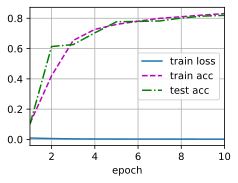

In [4]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)


lenet.apply(init_weights)

lr, num_epochs, batch_size = 0.9, 10, 256
root = (Path("").resolve().parent.parent / Path("data")).as_posix()
dataset = FashionMNISTDataset(root=root)
train_dataloader, test_dataloader = dataset.get_dataloader(batch_size=batch_size)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lenet.parameters(), lr=lr)

dl_modules.train(lenet, train_dataloader, test_dataloader, optimizer, loss, num_epochs)

# AlexNet

精简版本的AlexNet

![从LeNet（左）到AlexNet（右）](../img/alexnet.svg)

In [5]:
alexnet = nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10),
)

In [6]:
X = torch.randn(1, 1, 224, 224)
for layer in alexnet:
    X = layer(X)
    print(layer.__class__.__name__, "output shape:\t", X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

train loss 0.003, train acc 0.880, test acc 0.877
3443.3 examples/sec on cuda:0


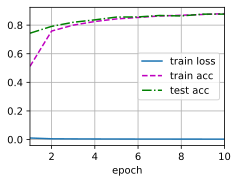

In [7]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)


alexnet.apply(init_weights)

batch_size = 128
root = (Path("").resolve().parent.parent / Path("data")).as_posix()
dataset = FashionMNISTDataset(root=root, resize=224)
train_dataloader, test_dataloader = dataset.get_dataloader(batch_size=batch_size)

lr, num_epochs = 0.01, 10
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(alexnet.parameters(), lr=lr)

dl_modules.train(alexnet, train_dataloader, test_dataloader, optimizer, loss, num_epochs)

# VGG网络

与AlexNet、LeNet一样，VGG网络可以分为两部分：第一部分主要由卷积层和汇聚层组成，第二部分由全连接层组成。

![从AlexNet到VGG，它们本质上都是块设计。](../imgs/vgg.svg)

VGG神经网络连接的VGG块（在`vgg_block`函数中定义）。其中有超参数变量`conv_arch`。该变量指定了每个VGG块里卷积层个数和输出通道数。全连接模块则与AlexNet中的相同。

原始VGG网络有5个卷积块，其中前两个块各有一个卷积层，后三个块各包含两个卷积层。
第一个模块有64个输出通道，每个后续模块将输出通道数量翻倍，直到该数字达到512。由于该网络使用8个卷积层和3个全连接层，因此它通常被称为VGG-11。


In [8]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

In [9]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for num_convs, out_channels in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks,
        nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 10)
    )


conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
vggnet = vgg(conv_arch)

In [10]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in vggnet:
    X = blk(X)
    print(blk.__class__.__name__, "output shape:\t", X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


[**由于VGG-11比AlexNet计算量更大，因此我们构建了一个通道数较少的网络**]，足够用于训练Fashion-MNIST数据集。

train loss 0.002, train acc 0.915, test acc 0.905
1726.1 examples/sec on cuda:0


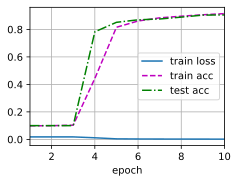

In [11]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
vggnet = vgg(small_conv_arch)

lr, num_epochs, batch_size = 0.05, 10, 128
root = (Path("").resolve().parent.parent / Path("data")).as_posix()
dataset = FashionMNISTDataset(root=root, resize=224)
train_dataloader, test_dataloader = dataset.get_dataloader(batch_size=batch_size)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vggnet.parameters(), lr=lr)

dl_modules.train(vggnet, train_dataloader, test_dataloader, optimizer, loss, num_epochs)

# 网络中的网络（NiN）

## [**NiN块**]

NiN块以一个普通卷积层开始，后面是两个$1 \times 1$的卷积层。这两个$1 \times 1$卷积层充当带有ReLU激活函数的逐像素全连接层。
第一层的卷积窗口形状通常由用户设置。
随后的卷积窗口形状固定为$1 \times 1$。

![对比 VGG 和 NiN 及它们的块之间主要架构差异。](../imgs/nin.svg)

In [12]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU(),
    )

In [13]:
ninnet = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten(),
)

In [14]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in ninnet:
    X = layer(X)
    print(layer.__class__.__name__, "output shape:\t", X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


train loss 0.005, train acc 0.773, test acc 0.773
2671.5 examples/sec on cuda:0


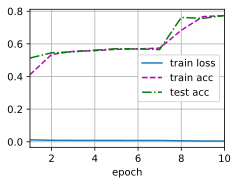

In [15]:
lr, num_epochs, batch_size = 0.005, 10, 128
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ninnet.parameters(), lr=lr)
root = (Path("").resolve().parent.parent / Path("data")).as_posix()
dataset = FashionMNISTDataset(root=root, resize=224)
train_dataloader, test_dataloader = dataset.get_dataloader(batch_size=batch_size)
dl_modules.train(ninnet, train_dataloader, test_dataloader, optimizer, loss, num_epochs)

# 含并行连结的网络（GoogLeNet）

## [**Inception块**]

![Inception块的架构。](../imgs/inception.svg)

Inception块由四条并行路径组成。
前三条路径使用窗口大小为$1\times 1$、$3\times 3$和$5\times 5$的卷积层，从不同空间大小中提取信息。
中间的两条路径在输入上执行$1\times 1$卷积，以减少通道数，从而降低模型的复杂性。
第四条路径使用$3\times 3$最大汇聚层，然后使用$1\times 1$卷积层来改变通道数。
这四条路径都使用合适的填充来使输入与输出的高和宽一致，最后我们将每条线路的输出在通道维度上连结，并构成Inception块的输出。在Inception块中，通常调整的超参数是每层输出通道数。

In [16]:
class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

为什么GoogLeNet这个网络如此有效呢？
考虑一下滤波器（filter）的组合，它们可以用各种滤波器尺寸探索图像，这意味着不同大小的滤波器可以有效地识别不同范围的图像细节。
同时可以为不同的滤波器分配不同数量的参数。

## [**GoogLeNet模型**]

GoogLeNet一共使用9个Inception块和全局平均汇聚层的堆叠来生成其估计值。Inception块之间的最大汇聚层可降低维度。
第一个模块类似于AlexNet和LeNet，Inception块的组合从VGG继承，全局平均汇聚层避免了在最后使用全连接层。

![GoogLeNet架构。](../imgs/inception-full.svg)


In [17]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [18]:
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)

In [19]:
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)

In [20]:
b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)

In [21]:
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
)

googlenet = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [22]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in googlenet:
    X = layer(X)
    print(layer.__class__.__name__, "output shape:\t", X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


train loss 0.002, train acc 0.921, test acc 0.908
683.7 examples/sec on cuda:0


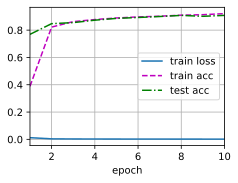

In [23]:
lr, num_epochs, batch_size = 1e-3, 10, 128
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(googlenet.parameters(), lr=lr)
root = (Path("").resolve().parent.parent / Path("data")).as_posix()
dataset = FashionMNISTDataset(root=root, resize=224)
train_dataloader, test_dataloader = dataset.get_dataloader(batch_size=batch_size)
dl_modules.train(googlenet, train_dataloader, test_dataloader, optimizer, loss, num_epochs)